In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as matplotlibPolygon
from multiprocessing import Pool, cpu_count
from shapely.affinity import scale
from shapely.strtree import STRtree
from scipy.spatial import ConvexHull

import json
from rtree import index

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered_new/"
polygon_dir  = "/data/projects/robin/segmentation/output-new-seg/segmentation_polygons.json"

with open(polygon_dir, 'r') as file:
    polygon_dict = json.load(file)

adata_with_domain = sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")

In [3]:
cell_names = [str(polygon_dict['geometries'][i]['cell']) for i in range(len(polygon_dict['geometries']))]
cell_coordinates = [polygon_dict['geometries'][i]['coordinates'][0] for i in range(len(polygon_dict['geometries']))]
cell_names = np.array(cell_names)
df_polygon = pd.DataFrame({
    'names' : cell_names,
    'coords' : cell_coordinates})
df_polygon.index = df_polygon['names']
df_polygon

,names,coords
names,,
185983,185983,"[[3714.5618, 20479.88], [3714.3374, 20482.264]..."
371966,371966,"[[7231.8833, 3040.58], [7232.0537, 3039.7822],..."
221120,221120,"[[7118.4053, 19706.914], [7115.494, 19704.934]..."
92533,92533,"[[1470.7107, 14148.667], [1470.7705, 14150.08]..."
76914,76914,"[[2689.5303, 12016.144], [2688.5042, 12016.396..."
...,...,...
300650,300650,"[[1215.121, 13696.862], [1213.2627, 13699.764]..."
150325,150325,"[[6032.6353, 14348.5], [6033.725, 14348.425], ..."
336545,336545,"[[7494.6553, 8513.94], [7494.7266, 8513.655], ..."


In [27]:
sample = 'X3'

# Read anndata
adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')

# Add "is_in_polygon" col. to the data
is_in_polygon = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'is_in_polygon']
nichepca_glom_no = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'nichepca_glom_no']
polygon_id = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'polygon_flags']
adata.obs['is_in_polygon'] = list(is_in_polygon)
adata.obs['nichepca_glom_no'] = list(nichepca_glom_no)
adata.obs['polygon_id'] = list(polygon_id)

# Restrict anndata to PECs in polygon
adata = adata[adata.obs['is_in_polygon']]
adata = adata[adata.obs['celltype_l1'] == 'PEC']

print(adata.shape)

(199, 480)


In [29]:
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,n_genes,celltype_l1,celltype_l1_codes,celltype_l1_prob,Slide_ID,sample,label,is_in_polygon,nichepca_glom_no,polygon_id
cell_CR9fbacb852-120344,6672.328824,11956.891184,29.637057,4,144,1.434,3.907,100.40,0.9976,0.9612,...,84,PEC,28,1.000000,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120609,6760.715066,11903.551972,28.207916,4,53,2.238,1.539,23.68,0.9980,0.8981,...,31,PEC,28,0.999856,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120674,6697.248527,11976.358136,26.449189,4,11,1.069,1.313,10.29,0.9850,0.9636,...,10,PEC,28,0.999999,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120749,6589.813991,12094.360368,28.374838,4,91,1.553,3.386,58.61,0.9961,0.9615,...,54,PEC,28,1.000000,0011186,x3,anca,True,Other,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120809,6594.551579,12097.690190,27.184932,4,29,1.508,4.510,19.23,0.9956,0.9076,...,17,PEC,28,0.996063,0011186,x3,anca,True,Other,0_0011186_ANCA_X3_slide2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-333717,7223.965984,13588.029368,27.616982,4,38,1.859,3.643,20.44,0.9980,0.7258,...,9,PEC,28,0.595482,0011186,x3,anca,True,4,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-333772,6878.757563,13211.421186,26.365888,1,51,1.098,2.446,46.46,0.9981,0.9086,...,36,PEC,28,1.000000,0011186,x3,anca,True,1,1_0011186_ANCA_X3_slide2
cell_CR9fbacb852-334793,7303.562636,13720.492364,27.366146,1,11,2.041,2.923,5.39,0.9972,0.9182,...,8,PEC,28,0.999994,0011186,x3,anca,True,6,6_0011186_ANCA_X3_slide2
cell_CR9fbacb852-341963,7907.922214,12563.874786,26.889959,1,28,2.414,3.425,11.60,0.9978,0.7943,...,7,PEC,28,0.989304,0011186,x3,anca,True,2,2_0011186_ANCA_X3_slide2


In [30]:
# adata = adata[adata.obs['nichepca_glom_no'] == '4']
adata = adata[adata.obs['polygon_id'] == '4_0011186_ANCA_X3_slide2']
adata.obs

In [31]:
# Get the cell that exsit in both anndata and cell boundries
cell_name = [i.split('-')[1] for i in adata.obs.index]
adata.obs['cell_name'] = cell_name
adata = adata[adata.obs['cell_name'].isin(df_polygon['names'])]
df_polygon_i = df_polygon.loc[adata.obs['cell_name']]

print(adata.shape)

(34, 480)


In [33]:
# Choose the protein channel and read the data
ch = 9

# Read the registered protein image
pc_image = plt.imread(pc_dir + f"Phenocycler_Channel{(ch):02}_{sample}_Level2.ome.tiff")
w, h = pc_image.shape

# Add the image to the anndata
slide_id = adata.obs['Slide_ID'][0]
adata.uns['spatial'][slide_id]['images']['Ki67'] = pc_image
adata.uns['spatial'][slide_id]['scalefactors']['tissue_Ki67_scalef'] = 1
adata.uns['spatial'][slide_id]['scalefactors']['tissue_dapi_LEVEL1_cropped_scalef'] = 1

In [34]:
# Get the shift to match cell poition on pixels
x_shift = adata.obs['x'][0] - adata.obsm['spatial'][0, 0]
y_shift = adata.obs['y'][0] - adata.obsm['spatial'][0, 1]
x_shift, y_shift

(4342.0, 10781.0)

In [35]:
adata.obs['Ki67'] = 0

pic_val_sum = {name: 0 for name in adata.obs.index}

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
    
    cell_name = idx.split('-')[1]

    coords = df_polygon_i.loc[cell_name, 'coords']
    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    polygon_obj = Polygon(coords)
    
    i_min, j_min = coords.min(axis=0) - 50
    i_max, j_max = coords.max(axis=0) + 50

    i_min = 0 if i_min < 0 else i_min
    j_min = 0 if j_min < 0 else j_min
    i_max = h if i_max > w else i_max
    j_max = w if j_max > h else j_max
    
    for i in range(int(i_min), int(i_max)):
        for j in range(int(j_min), int(j_max)): 
            pic_val = pc_image[j, i]
            if pic_val > 0:
                point = Point(i, j)
                if polygon_obj.covers(point):
                    pic_val_sum[idx] += pic_val

adata.obs['Ki67'] = list(pic_val_sum.values())
(adata.obs['Ki67']).sum()

34it [00:00, 44.81it/s]


310

In [36]:
(adata.obs['Ki67'] > 0).sum() / len(adata.obs['Ki67'])

0.23529411764705882

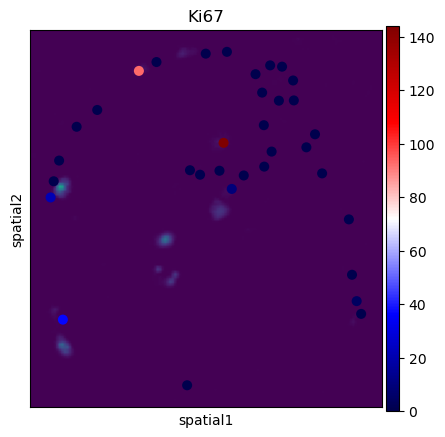

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
slide_id = adata.obs['Slide_ID'][0]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = 'Ki67',
              color = 'Ki67',
              size = .1,
              ax = ax,
              cmap='seismic',
              show = True)

34it [00:00, 974.51it/s]


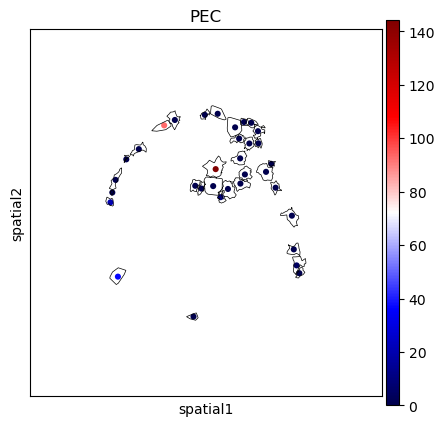

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
slide_id = adata.obs['Slide_ID'][0]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = ['Ki67', 'dapi_LEVEL1_cropped',None][2],
              color = 'Ki67',
              size = .1,
              ax = ax,
              cmap='seismic',
              title="PEC",
              show = False,
             )


ki67_values = adata.obs['Ki67'].values
ki67_min, ki67_max = ki67_values.min(), ki67_values.max()
normalized_values = (ki67_values - ki67_min) / (ki67_max - ki67_min)
cmap = plt.get_cmap('spring')
colors = [cmap(value) for value in normalized_values]

coords_all = np.array([]).reshape([0, 2])

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
    
    cell_name = idx.split('-')[1]
    coords = df_polygon_i.loc[cell_name, 'coords']

    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    coords_all = np.concatenate([coords_all, coords])

    polygon_obj = matplotlibPolygon(coords, 
                          facecolor="none",
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5,
                         )


    ax.add_patch(polygon_obj)


i_min, j_min = coords_all.min(axis=0) - 50
i_max, j_max = coords_all.max(axis=0) + 50

ax.set_xlim(i_min, i_max)
ax.set_ylim(j_min, j_max)
ax.invert_yaxis()

34it [00:00, 820.18it/s]


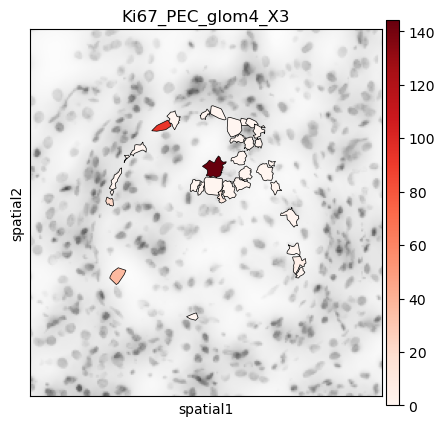

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
slide_id = adata.obs['Slide_ID'][0]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = ['Ki67', 'dapi_LEVEL1_cropped',None][1],
              color = 'Ki67',
              size = 0,
              ax = ax,
              cmap='Reds',
              title="Ki67_PEC_glom4_X3",
              show = False,
             )


ki67_values = adata.obs['Ki67'].values
ki67_min, ki67_max = ki67_values.min(), ki67_values.max()
normalized_values = (ki67_values - ki67_min) / (ki67_max - ki67_min)
cmap = plt.get_cmap('Reds')
colors = [cmap(value) for value in normalized_values]

coords_all = np.array([]).reshape([0, 2])

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
    
    cell_name = idx.split('-')[1]
    coords = df_polygon_i.loc[cell_name, 'coords']

    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    coords_all = np.concatenate([coords_all, coords])

    polygon_obj = matplotlibPolygon(coords, 
                          facecolor=colors[n],
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5,
                         )


    ax.add_patch(polygon_obj)


i_min, j_min = coords_all.min(axis=0) - 50
i_max, j_max = coords_all.max(axis=0) + 50

ax.set_xlim(i_min, i_max)
ax.set_ylim(j_min, j_max)
ax.invert_yaxis()

plt.savefig("Ki67_PEC_glom4_X3.pdf", bbox_inches="tight")
plt.show()

34it [00:00, 970.39it/s]


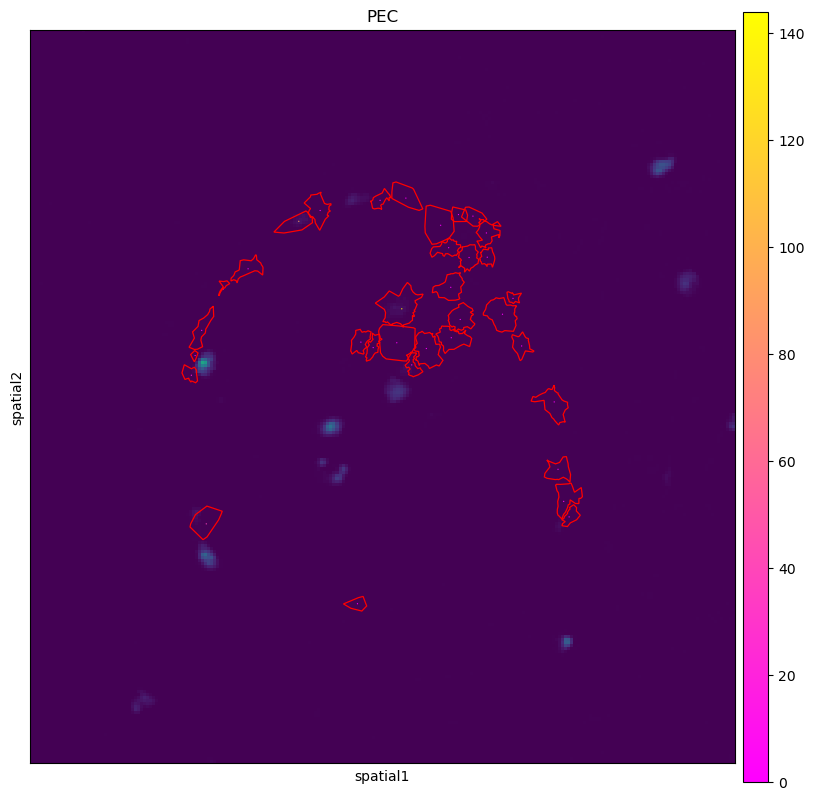

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
slide_id = adata.obs['Slide_ID'][0]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = ['Ki67', None][0],
              color = 'Ki67',
              size = .01,
              ax = ax,
              cmap='spring',
              title="PEC",
              show = False,
             )

coords_all = np.array([]).reshape([0, 2])

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
    
    cell_name = idx.split('-')[1]
    coords = df_polygon_i.loc[cell_name, 'coords']

    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    coords_all = np.concatenate([coords_all, coords])
    # polygon_obj = Polygon(coords)
    polygon_obj = matplotlibPolygon(coords, 
                          facecolor="none",
                          edgecolor="red",
                          alpha=1,
                          linewidth=0.9,
                         )


    ax.add_patch(polygon_obj)


i_min, j_min = coords_all.min(axis=0) - 50
i_max, j_max = coords_all.max(axis=0) + 50

ax.set_xlim(i_min, i_max)
ax.set_ylim(j_min, j_max)
ax.invert_yaxis()